# Laboratory Work 1: Full Implementation

This notebook contains the full implementation from `lab1.py` for preprocessing, normalization, modeling, and drift monitoring on Titanic and Iris datasets.


In [17]:
#!/usr/bin/env python3
"""Laboratory Work 1: preprocessing, normalization, modeling, and drift monitoring on Titanic."""

from itertools import product
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp, boxcox, yeojohnson
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    QuantileTransformer,
    Normalizer,
)
from tqdm import tqdm
try:
    from IPython.display import Image, display
except ImportError:
    # If not in Jupyter, create dummy functions
    def display(*args, **kwargs):
        print(*args)
    Image = None

try:
    from cuml.ensemble import RandomForestRegressor as CuRandomForestRegressor
    from cuml.linear_model import LogisticRegression as CuLogisticRegression
except ImportError:  # GPU libs not available
    CuRandomForestRegressor = None
    CuLogisticRegression = None

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


## Constants and Configuration


In [18]:
DATA_DIR = Path("data")
FIGURES_DIR = Path("figures")
RESULTS_DIR = Path("results")

MISSING_STRATEGIES = [
    "mean",
    "median",
    "knn",
    "most_frequent",
    "constant_zero",
    "iterative",
    "drop",
]
OUTLIER_METHODS = ["none", "winsorization", "log", "boxcox", "yeojohnson"]
SCALING_METHODS = ["none", "standard", "minmax", "robust", "quantile", "unit_vector"]

DATASETS = {
    "1": {
        "name": "Titanic",
        "description": "Passengers and survival outcome",
        "path": DATA_DIR / "Titanic-Dataset.csv",
        "classification_target": "survived",
        "regression_target": "fare",
        "classification_features": ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"],
        "classification_numeric": ["pclass", "age", "sibsp", "parch", "fare"],
        "classification_categorical": ["sex", "embarked"],
        "classification_allowed_values": [0, 1],
        "regression_features": ["pclass", "sex", "age", "sibsp", "parch", "embarked"],
        "regression_numeric": ["pclass", "age", "sibsp", "parch"],
        "regression_categorical": ["sex", "embarked"],
    },
    "2": {
        "name": "Iris",
        "description": "Iris flower dataset",
        "path": DATA_DIR / "Iris.csv",
        "classification_target": "species",
        "regression_target": "petal_length",
        "classification_features": ["sepal_length", "sepal_width", "petal_length", "petal_width"],
        "classification_numeric": ["sepal_length", "sepal_width", "petal_length", "petal_width"],
        "classification_categorical": [],
        "classification_allowed_values": ["setosa", "versicolor", "virginica"],
        "regression_features": ["sepal_length", "sepal_width", "petal_width"],
        "regression_numeric": ["sepal_length", "sepal_width", "petal_width"],
        "regression_categorical": [],
    },

}

DEFAULT_DATASET_ID = "1"

CLASSIFICATION_SCORING = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall": make_scorer(recall_score, average="weighted", zero_division=0),
    "f1": make_scorer(f1_score, average="weighted", zero_division=0),
}
REGRESSION_SCORING = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}


## Helper Functions


In [19]:
def build_classification_estimator(use_gpu: bool):
    """Return CPU or GPU logistic regression."""
    if use_gpu and CuLogisticRegression is not None:
        return CuLogisticRegression()
    return LogisticRegression(solver="liblinear", max_iter=500, random_state=42)


def build_regression_estimator(use_gpu: bool):
    """Return CPU or GPU random forest regressor."""
    if use_gpu and CuRandomForestRegressor is not None:
        return CuRandomForestRegressor(n_estimators=100, random_state=42)
    return RandomForestRegressor(n_estimators=100, random_state=42)


def get_dataset_config(dataset_id: str):
    """Return metadata for the chosen dataset."""
    config = DATASETS.get(str(dataset_id))
    if config is None:
        raise ValueError(f"Unknown dataset `{dataset_id}`; choose from {list(DATASETS.keys())}")
    return config


def log_stage(name: str, status: str, info: str = ""):
    """Simple status indicator for the CLI."""
    timestamp = pd.Timestamp.now().strftime("%H:%M:%S")
    payload = f"{timestamp} | {name:<25} | {status}"
    if info:
        payload += f" | {info}"
    print(payload)


## Data Loading and Preprocessing Functions


In [20]:
def load_dataset(config: dict, max_rows: int = None) -> pd.DataFrame:
    """Load the requested CSV and ensure required columns exist."""
    path = Path(config["path"])
    if not path.exists():
        raise FileNotFoundError(f"Dataset {config['name']} not found at {path}")
    raw = pd.read_csv(path)
    raw.columns = raw.columns.str.lower()
    required = set(
        config["classification_features"]
        + config["regression_features"]
        + [config["classification_target"], config["regression_target"]]
    )
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Dataset missing columns: {missing}")
    df = raw.copy()
    if max_rows is not None and max_rows > 0:
        df = df.head(max_rows)
    # Normalize numeric columns
    numeric_cols = set(
        config["classification_numeric"] + config["regression_numeric"]
    )
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df


def apply_drop_strategy(df, numeric_features, target_cols, strategy):
    """Drop rows when the 'drop' imputer strategy is selected."""
    if strategy != "drop":
        return df
    return df.dropna(subset=list(numeric_features) + list(target_cols))


def get_numeric_imputer(strategy: str):
    """Returns an imputer for numeric features according to the strategy."""
    if strategy == "mean":
        return SimpleImputer(strategy="mean")
    if strategy == "median":
        return SimpleImputer(strategy="median")
    if strategy == "knn":
        return KNNImputer(n_neighbors=5)
    if strategy == "most_frequent":
        return SimpleImputer(strategy="most_frequent")
    if strategy == "constant_zero":
        return SimpleImputer(strategy="constant", fill_value=0)
    if strategy == "iterative":
        return IterativeImputer(random_state=42)
    if strategy == "drop":
        return SimpleImputer(strategy="mean")
    raise ValueError(f"Unsupported numeric imputer: {strategy}")


def get_scaler(name: str):
    """Returns a scaler or None if scaling is not needed."""
    if name == "standard":
        return StandardScaler()
    if name == "minmax":
        return MinMaxScaler()
    if name == "robust":
        return RobustScaler()
    if name == "quantile":
        return QuantileTransformer(output_distribution="normal", random_state=42, n_quantiles=150)
    if name == "unit_vector":
        return Normalizer()
    if name == "none":
        return None
    raise ValueError(f"Unknown scaling option: {name}")


def detect_outliers(df: pd.DataFrame, numeric_cols, method="none") -> pd.DataFrame:
    """Применяет выбранную стратегию трансформации для обработки выбросов."""
    if method == "none":
        return df.copy()

    result_df = df.copy()
    for col in numeric_cols:
        series = df[col]
        if series.empty:
            continue

        # Обрабатываем только положительные значения для log, boxcox
        if method in ["log", "boxcox"]:
            min_val = series.min()
            if min_val <= 0:
                # Добавляем смещение для положительности
                shift = abs(min_val) + 1e-6
                series = series + shift

        if method == "winsorization":
            # Winsorization: заменяем экстремальные значения на квантили
            lower = series.quantile(0.05)
            upper = series.quantile(0.95)
            result_df[col] = series.clip(lower=lower, upper=upper).astype(series.dtype)
        elif method == "log":
            # Логарифмическое преобразование
            result_df[col] = np.log(series).astype(float)
        elif method == "boxcox":
            # Box-Cox преобразование
            try:
                transformed, _ = boxcox(series.dropna())
                result_df[col] = result_df[col].astype(float)
                result_df.loc[series.notna(), col] = transformed.astype(float)
            except ValueError:
                # Если Box-Cox не сработал, используем логарифм
                result_df[col] = result_df[col].astype(float)
                result_df[col] = np.log(series + abs(series.min()) + 1e-6).astype(float)
        elif method == "yeojohnson":
            # Yeo-Johnson преобразование
            try:
                transformed, _ = yeojohnson(series.dropna())
                result_df[col] = result_df[col].astype(float)
                result_df.loc[series.notna(), col] = transformed.astype(float)
            except ValueError:
                # Если Yeo-Johnson не сработал, оставляем без изменений
                pass
        else:
            raise ValueError(f"Unsupported outlier method: {method}")
    return result_df



In [21]:
def build_preprocessing_pipeline(
    numeric_features, categorical_features, numeric_imputer, scaler, estimator
) -> Pipeline:
    """Builds a column transformer and model in a single pipeline."""
    numeric_steps = [("imputer", numeric_imputer)]
    if scaler is not None:
        numeric_steps.append(("scaler", scaler))

    numeric_pipeline = Pipeline(numeric_steps)
    categorical_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features),
        ],
        remainder="drop",
    )

    return Pipeline([("preprocessor", preprocessor), ("estimator", estimator)])


## Model Evaluation Functions


In [22]:
def evaluate_classification(df, config, outlier_method, imputer_name, scaler_name, use_gpu=False):
    """Cross-validation of logistic regression with different preprocessing options."""
    target = config["classification_target"]
    features = config["classification_features"]
    numeric = config["classification_numeric"]
    categorical = config["classification_categorical"]
    prepared = apply_drop_strategy(df, numeric + categorical, [target], imputer_name)
    filtered = detect_outliers(prepared, numeric, method=outlier_method)
    filtered = filtered.dropna(subset=[target])
    allowed = config.get("classification_allowed_values")
    if allowed:
        filtered = filtered[filtered[target].isin(allowed)]
    if filtered.empty:
        raise ValueError("No data after outlier filtering.")

    X = filtered[features]
    y = filtered[target]
    numeric_imputer = get_numeric_imputer(imputer_name)
    scaler = get_scaler(scaler_name)
    pipeline = build_preprocessing_pipeline(
        numeric,
        categorical,
        numeric_imputer,
        scaler,
        build_classification_estimator(use_gpu),
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(
        pipeline,
        X,
        y,
        cv=cv,
        scoring=CLASSIFICATION_SCORING,
        n_jobs=1,
    )

    return {
        "Outlier": outlier_method,
        "Imputer": imputer_name,
        "Scaler": scaler_name,
        "Accuracy": results["test_accuracy"].mean(),
        "Precision": results["test_precision"].mean(),
        "Recall": results["test_recall"].mean(),
        "F1": results["test_f1"].mean(),
        "SampleCount": X.shape[0],
        "FoldCount": cv.get_n_splits(X, y),
    }


def evaluate_regression(df, config, outlier_method, imputer_name, scaler_name, use_gpu=False):
    """Cross-validation of random forest with various preprocessing options."""
    target = config["regression_target"]
    features = config["regression_features"]
    numeric = config["regression_numeric"]
    categorical = config["regression_categorical"]
    prepared = apply_drop_strategy(df, numeric + categorical, [target], imputer_name)
    filtered = detect_outliers(prepared, numeric, method=outlier_method)
    filtered = filtered.dropna(subset=[target])
    if filtered.empty:
        raise ValueError("No data after outlier filtering for regression.")

    X = filtered[features]
    y = filtered[target]
    numeric_imputer = get_numeric_imputer(imputer_name)
    scaler = get_scaler(scaler_name)
    estimator = build_regression_estimator(use_gpu)
    pipeline = build_preprocessing_pipeline(
        numeric,
        categorical,
        numeric_imputer,
        scaler,
        estimator,
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(
        pipeline, X, y, cv=cv, scoring=REGRESSION_SCORING, n_jobs=1
    )
    return {
        "Outlier": outlier_method,
        "Imputer": imputer_name,
        "Scaler": scaler_name,
        "RMSE": -results["test_rmse"].mean(),
        "MAE": -results["test_mae"].mean(),
        "R2": results["test_r2"].mean(),
        "SampleCount": X.shape[0],
        "FoldCount": cv.get_n_splits(X, y),
    }


## Drift Detection Functions


In [23]:
def detect_drift(reference, current, numeric_features, threshold=0.05) -> pd.DataFrame:
    """Performs KS-test on each numeric feature to detect drift."""
    records = []
    for col in numeric_features:
        ref_vals = reference[col].dropna()
        curr_vals = current[col].dropna()
        if ref_vals.empty or curr_vals.empty:
            records.append(
                {"feature": col, "p_value": np.nan, "drift": False, "note": "not enough samples"}
            )
            continue
        _, p_value = ks_2samp(ref_vals, curr_vals)
        records.append({"feature": col, "p_value": p_value, "drift": p_value < threshold, "note": ""})
    return pd.DataFrame(records).sort_values("p_value")


## Visualization Functions


In [24]:
def ensure_figures_dir():
    """Ensures the figures directory exists."""
    FIGURES_DIR.mkdir(exist_ok=True)


def ensure_results_dir():
    """Ensures the results directory exists."""
    RESULTS_DIR.mkdir(exist_ok=True)


def plot_missingness(df: pd.DataFrame, config: dict):
    """Saves a heatmap showing missing value patterns."""
    subset = df[config["classification_features"] + [config["classification_target"]]]
    # Create a boolean matrix where True = missing
    missing_matrix = subset.isna()
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(missing_matrix, cbar=False, cmap="Reds", ax=ax,
                yticklabels=False, xticklabels=missing_matrix.columns)
    ax.set_title("Missing Values Heatmap (Red = Missing)")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fig.tight_layout()
    fig.savefig(FIGURES_DIR / "missing_values.png", bbox_inches="tight")
    plt.close(fig)


def plot_outlier_distributions(df: pd.DataFrame, config: dict):
    """Saves boxplots showing outliers for numeric features."""
    numeric_cols = config["classification_numeric"][:4]  # Show up to 4 features
    if not numeric_cols:
        return
    subset = df[numeric_cols].dropna()
    if subset.empty:
        return
    # Melt for boxplot
    melted = subset.melt(var_name="Feature", value_name="Value")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Feature", y="Value", data=melted, ax=ax, palette="Set2")
    ax.set_title("Boxplots of Numeric Features (showing outliers)")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fig.tight_layout()
    fig.savefig(FIGURES_DIR / "outlier_boxplots.png", bbox_inches="tight")
    plt.close(fig)


def plot_metric_comparison(class_df: pd.DataFrame, reg_df: pd.DataFrame):
    """Visualizes the impact of outlier filtering on accuracy and RMSE."""
    acc_by_outlier = (
        class_df.groupby("Outlier")["Accuracy"].mean().reindex(OUTLIER_METHODS)
    )
    rmse_by_outlier = reg_df.groupby("Outlier")["RMSE"].mean().reindex(OUTLIER_METHODS)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    acc_by_outlier.plot.bar(ax=axes[0], color="tab:green", edgecolor="black")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Classification accuracy by outlier filter")
    rmse_by_outlier.plot.bar(ax=axes[1], color="tab:orange", edgecolor="black")
    axes[1].set_ylabel("RMSE")
    axes[1].set_title("Regression RMSE by outlier filter")
    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=0)
    fig.tight_layout()
    fig.savefig(FIGURES_DIR / "outlier_metric_comparison.png", bbox_inches="tight")
    plt.close(fig)


def plot_correlation_heatmap(df: pd.DataFrame, config: dict):
    """Saves a correlation heatmap of numeric features."""
    numeric = df[config["classification_numeric"]].copy()
    corr = numeric.corr()
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0, ax=ax)
    ax.set_title("Numeric Correlation Heatmap")
    fig.tight_layout()
    fig.savefig(FIGURES_DIR / "numeric_correlation_heatmap.png", bbox_inches="tight")
    plt.close(fig)


def plot_target_boxplot(df: pd.DataFrame, config: dict):
    """Saves boxplots of key features split by target feature."""
    target = config["classification_target"]
    numeric_cols = config["classification_numeric"][:2]
    if not numeric_cols:
        return
    subset = df[[target] + numeric_cols].dropna()
    melted = subset.melt(id_vars=target, var_name="feature", value_name="value")
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(x="feature", y="value", hue=target, data=melted, palette="Set2", ax=ax)
    ax.set_title(f"Feature distributions by {target}")
    ax.legend(title=target)
    fig.tight_layout()
    fig.savefig(FIGURES_DIR / "feature_survival_boxplot.png", bbox_inches="tight")
    plt.close(fig)


## Analysis Pipeline

The following cells execute the complete analysis pipeline step by step.


### Step 1: Configuration

Set the dataset and analysis parameters.

### Step 2: Load Dataset


In [25]:
# Configuration
DATASET_ID = "1"  # "1" for Titanic, "2" for Iris
MAX_ROWS = None  # Row limit (None for all data)
USE_GPU = False  # Use GPU (requires cuML)

# Check GPU availability
if USE_GPU:
    if CuLogisticRegression is None or CuRandomForestRegressor is None:
        print("⚠️  GPU mode requested but cuML not available, using CPU estimators")
        USE_GPU = False
    else:
        print("✓ GPU mode enabled (cuML available)")
else:
    print("Using CPU mode")


Using CPU mode


### Step 3: Data Overview


### Data Overview

Load and explore the dataset. Change `DATASET_ID` and `MAX_ROWS` if needed.


In [26]:
# Load dataset
config = get_dataset_config(DATASET_ID)
df = load_dataset(config, max_rows=MAX_ROWS)

print(f"Using dataset {config['name']} (ID {DATASET_ID}): {config['description']}")
print(f"Table size: {df.shape}")
log_stage("Data load", "DONE", f"{df.shape[0]} rows × {df.shape[1]} cols")

print("\nFirst few rows:")
display(df.head())
print("\nStatistical summary:")
display(df.describe(include="all").T)


Using dataset Titanic (ID 1): Passengers and survival outcome
Table size: (891, 12)
17:42:23 | Data load                 | DONE | 891 rows × 12 cols

First few rows:


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Statistical summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
passengerid,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


### Step 4: Classification Evaluation


In [27]:
# Run classification evaluation
classification_results = []
classification_combos = list(product(OUTLIER_METHODS, MISSING_STRATEGIES, SCALING_METHODS))
log_stage("Classification sweep", "START", f"{len(classification_combos)} combinations")

for outlier, imputer, scaler in tqdm(classification_combos, desc="Classification", unit="combo"):
    try:
        record = evaluate_classification(df, config, outlier, imputer, scaler, use_gpu=USE_GPU)
        record["Dataset"] = config["name"]
        classification_results.append(record)
    except Exception as e:
        print(f"Error with {outlier}/{imputer}/{scaler}: {e}")
        continue

log_stage("Classification sweep", "DONE")

classification_df = pd.DataFrame(classification_results)
classification_table = (
    classification_df
    .sort_values("Accuracy", ascending=False)
    .round({"Accuracy": 3, "Precision": 3, "Recall": 3, "F1": 3, "SampleCount": 0, "FoldCount": 0})
)

print("\nTop 5 classification pipelines (higher accuracy is better):")
display(classification_table.head(5))


17:42:23 | Classification sweep      | START | 336 combinations


Classification:  61%|██████    | 205/336 [00:21<00:01, 86.64combo/s]

Error with winsorization/mean/none: Length of values (714) does not match length of index (891)
Error with winsorization/mean/standard: Length of values (714) does not match length of index (891)
Error with winsorization/mean/minmax: Length of values (714) does not match length of index (891)
Error with winsorization/mean/robust: Length of values (714) does not match length of index (891)
Error with winsorization/mean/quantile: Length of values (714) does not match length of index (891)
Error with winsorization/mean/unit_vector: Length of values (714) does not match length of index (891)
Error with winsorization/median/none: Length of values (714) does not match length of index (891)
Error with winsorization/median/standard: Length of values (714) does not match length of index (891)
Error with winsorization/median/minmax: Length of values (714) does not match length of index (891)
Error with winsorization/median/robust: Length of values (714) does not match length of index (891)
Error

Classification:  75%|███████▍  | 251/336 [00:26<00:09,  9.21combo/s]/tmp/ipykernel_2765585/2405723877.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.37611598 0.         3.37611598 0.         3.37611598 3.37611598
 0.         3.37611598 3.37611598 1.3599459  3.37611598 0.
 3.37611598 3.37611598 3.37611598 1.3599459  3.37611598 1.3599459
 3.37611598 3.37611598 1.3599459  1.3599459  3.37611598 0.
 3.37611598 3.37611598 3.37611598 0.         3.37611598 3.37611598
 0.         0.         3.37611598 1.3599459  0.         0.
 3.37611598 3.37611598 3.37611598 3.37611598 3.37611598 1.3599459
 3.37611598 1.3599459  3.37611598 3.37611598 3.37611598 3.37611598
 3.37611598 3.37611598 3.37611598 3.37611598 0.         1.3599459
 0.         0.         1.3599459  3.37611598 1.3599459  3.37611598
 3.37611598 0.         0.         3.37611598 0.         3.37611598
 1.3599459  3.37611598 3.37611598 3.37611598 1.3599

17:43:03 | Classification sweep      | DONE

Top 5 classification pipelines (higher accuracy is better):


,Outlier,Imputer,Scaler,Accuracy,Precision,Recall,F1,SampleCount,FoldCount,Dataset
47,iqr,mean,unit_vector,0.813,0.807,0.813,0.807,598,5,Titanic
53,iqr,median,unit_vector,0.813,0.807,0.813,0.807,598,5,Titanic
59,iqr,knn,unit_vector,0.813,0.807,0.813,0.807,598,5,Titanic
77,iqr,iterative,unit_vector,0.813,0.807,0.813,0.807,598,5,Titanic
71,iqr,constant_zero,unit_vector,0.811,0.805,0.811,0.805,598,5,Titanic


### Step 5: Regression Evaluation


In [28]:
# Run regression evaluation
regression_data = df[config["regression_features"] + [config["regression_target"]]].dropna(
    subset=[config["regression_target"]]
)

regression_results = []
regression_combos = list(product(OUTLIER_METHODS, MISSING_STRATEGIES, SCALING_METHODS))
log_stage("Regression sweep", "START", f"{len(regression_combos)} combinations")

for outlier, imputer, scaler in tqdm(regression_combos, desc="Regression", unit="combo"):
    try:
        record = evaluate_regression(regression_data, config, outlier, imputer, scaler, use_gpu=USE_GPU)
        record["Dataset"] = config["name"]
        regression_results.append(record)
    except Exception as e:
        print(f"Error with {outlier}/{imputer}/{scaler}: {e}")
        continue

log_stage("Regression sweep", "DONE")

regression_df = pd.DataFrame(regression_results)
regression_table = (
    regression_df
    .sort_values("RMSE", ascending=True)
    .round({"RMSE": 3, "MAE": 3, "R2": 3, "SampleCount": 0, "FoldCount": 0})
)

print("\nTop 5 regression pipelines (lower RMSE is better):")
display(regression_table.head(5))


17:43:03 | Regression sweep          | START | 336 combinations


Regression:  50%|█████     | 168/336 [02:01<02:01,  1.39combo/s]

Error with winsorization/mean/none: Length of values (714) does not match length of index (891)
Error with winsorization/mean/standard: Length of values (714) does not match length of index (891)
Error with winsorization/mean/minmax: Length of values (714) does not match length of index (891)
Error with winsorization/mean/robust: Length of values (714) does not match length of index (891)
Error with winsorization/mean/quantile: Length of values (714) does not match length of index (891)
Error with winsorization/mean/unit_vector: Length of values (714) does not match length of index (891)
Error with winsorization/median/none: Length of values (714) does not match length of index (891)
Error with winsorization/median/standard: Length of values (714) does not match length of index (891)
Error with winsorization/median/minmax: Length of values (714) does not match length of index (891)
Error with winsorization/median/robust: Length of values (714) does not match length of index (891)
Error

Regression:  75%|███████▌  | 252/336 [02:36<00:57,  1.46combo/s]/tmp/ipykernel_2765585/2405723877.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.37611598 0.         3.37611598 0.         3.37611598 3.37611598
 0.         3.37611598 3.37611598 1.3599459  3.37611598 0.
 3.37611598 3.37611598 3.37611598 1.3599459  3.37611598 1.3599459
 3.37611598 3.37611598 1.3599459  1.3599459  3.37611598 0.
 3.37611598 3.37611598 3.37611598 0.         3.37611598 3.37611598
 0.         0.         3.37611598 1.3599459  0.         0.
 3.37611598 3.37611598 3.37611598 3.37611598 3.37611598 1.3599459
 3.37611598 1.3599459  3.37611598 3.37611598 3.37611598 3.37611598
 3.37611598 3.37611598 3.37611598 3.37611598 0.         1.3599459
 0.         0.         1.3599459  3.37611598 1.3599459  3.37611598
 3.37611598 0.         0.         3.37611598 0.         3.37611598
 1.3599459  3.37611598 3.37611598 3.37611598 1.3599459 

17:46:45 | Regression sweep          | DONE

Top 5 regression pipelines (lower RMSE is better):


,Outlier,Imputer,Scaler,RMSE,MAE,R2,SampleCount,FoldCount,Dataset
58,iqr,knn,quantile,32.765,11.392,0.316,667,5,Titanic
76,iqr,iterative,quantile,32.951,11.389,0.317,667,5,Titanic
72,iqr,iterative,none,33.016,11.386,0.313,667,5,Titanic
75,iqr,iterative,robust,33.026,11.443,0.313,667,5,Titanic
74,iqr,iterative,minmax,33.054,11.423,0.311,667,5,Titanic


### Step 6: Save results to CSV files


In [29]:
# Save results to CSV files
ensure_results_dir()
class_path = RESULTS_DIR / f"classification_full_{DATASET_ID}.csv"
reg_path = RESULTS_DIR / f"regression_full_{DATASET_ID}.csv"

classification_df.to_csv(class_path, index=False)
regression_df.to_csv(reg_path, index=False)

log_stage("Saving results", "DONE", f"{class_path.name}, {reg_path.name}")

print("\nFull classification results (sorted by Accuracy):")
display(classification_df.sort_values("Accuracy", ascending=False))

print("\nFull regression results (sorted by RMSE):")
display(regression_df.sort_values("RMSE", ascending=True))


17:46:45 | Saving results            | DONE | classification_full_1.csv, regression_full_1.csv

Full classification results (sorted by Accuracy):


,Outlier,Imputer,Scaler,Accuracy,Precision,Recall,F1,SampleCount,FoldCount,Dataset
47,iqr,mean,unit_vector,0.812703,0.807415,0.812703,0.807271,598,5,Titanic
53,iqr,median,unit_vector,0.812703,0.807415,0.812703,0.807271,598,5,Titanic
59,iqr,knn,unit_vector,0.812703,0.807415,0.812703,0.807271,598,5,Titanic
77,iqr,iterative,unit_vector,0.812703,0.807415,0.812703,0.807271,598,5,Titanic
71,iqr,constant_zero,unit_vector,0.811022,0.805358,0.811022,0.805299,598,5,Titanic
...,...,...,...,...,...,...,...,...,...,...
28,none,constant_zero,quantile,0.774415,0.775933,0.774415,0.774320,891,5,Titanic
41,none,drop,unit_vector,0.773791,0.773789,0.773791,0.771748,712,5,Titanic
173,winsorization,drop,unit_vector,0.773791,0.773789,0.773791,0.771748,712,5,Titanic
257,boxcox,drop,unit_vector,0.772392,0.772475,0.772392,0.770186,712,5,Titanic



Full regression results (sorted by RMSE):


,Outlier,Imputer,Scaler,RMSE,MAE,R2,SampleCount,FoldCount,Dataset
58,iqr,knn,quantile,32.764649,11.391612,0.316166,667,5,Titanic
76,iqr,iterative,quantile,32.950522,11.389459,0.316707,667,5,Titanic
72,iqr,iterative,none,33.015520,11.385916,0.313331,667,5,Titanic
75,iqr,iterative,robust,33.025622,11.443264,0.313362,667,5,Titanic
74,iqr,iterative,minmax,33.053659,11.422879,0.310888,667,5,Titanic
...,...,...,...,...,...,...,...,...,...
38,none,drop,minmax,40.560968,14.959932,0.293451,712,5,Titanic
39,none,drop,robust,40.566369,14.923220,0.292910,712,5,Titanic
41,none,drop,unit_vector,40.815471,16.822855,0.299560,712,5,Titanic
78,iqr,drop,none,40.945221,14.487169,0.253781,654,5,Titanic


### Step 7: Drift Diagnostics


In [30]:
# Perform drift detection
drift_df = df.dropna(subset=[config["classification_target"]])
allowed = config.get("classification_allowed_values")
if allowed:
    drift_df = drift_df[drift_df[config["classification_target"]].isin(allowed)]

if drift_df.shape[0] < 2 or drift_df[config["classification_target"]].nunique() < 2:
    print("Insufficient data for drift detection.")
    drift_report = pd.DataFrame([
        {"feature": col, "p_value": np.nan, "drift": False, "note": "not enough samples"}
        for col in config["classification_numeric"]
    ])
    drift_detected = False
else:
    reference, current = train_test_split(
        drift_df,
        test_size=0.5,
        stratify=drift_df[config["classification_target"]],
        random_state=42,
    )
    drift_report = detect_drift(reference, current, config["classification_numeric"])
    drift_detected = drift_report["drift"].any()

log_stage("Drift evaluation", "DONE")
print("\nData drift diagnostics (KS test per numeric feature):")
display(drift_report)
print(f"\nDrift detected? {'Yes (p < 0.05)' if drift_detected else 'No (all p >= 0.05)'} for at least one numeric feature.")


17:46:45 | Drift evaluation          | DONE

Data drift diagnostics (KS test per numeric feature):


,feature,p_value,drift,note
1,age,0.299135,False,
2,sibsp,0.622274,False,
4,fare,0.632219,False,
3,parch,0.987737,False,
0,pclass,1.000000,False,



Drift detected? No (all p >= 0.05) for at least one numeric feature.


### Step 8: Best Pipelines Summary


In [31]:
# Display best performing pipelines
best_classification = classification_table.iloc[0]
print("Best classification strategy:")
print(f"  Imputer={best_classification['Imputer']}, "
      f"Outlier={best_classification['Outlier']}, "
      f"Scaler={best_classification['Scaler']} => Accuracy {best_classification['Accuracy']}")

best_regression = regression_table.iloc[0]
print("\nBest regression strategy:")
print(f"  Imputer={best_regression['Imputer']}, "
      f"Outlier={best_regression['Outlier']}, "
      f"Scaler={best_regression['Scaler']} => RMSE {best_regression['RMSE']}")


Best classification strategy:
  Imputer=mean, Outlier=iqr, Scaler=unit_vector => Accuracy 0.813

Best regression strategy:
  Imputer=knn, Outlier=iqr, Scaler=quantile => RMSE 32.765


### Step 9: Visualizations


/tmp/ipykernel_2765585/431238874.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Feature", y="Value", data=melted, ax=ax, palette="Set2")


17:46:46 | Visualization             | START
17:46:46 | Visualization             | DONE

feature_survival_boxplot.png:


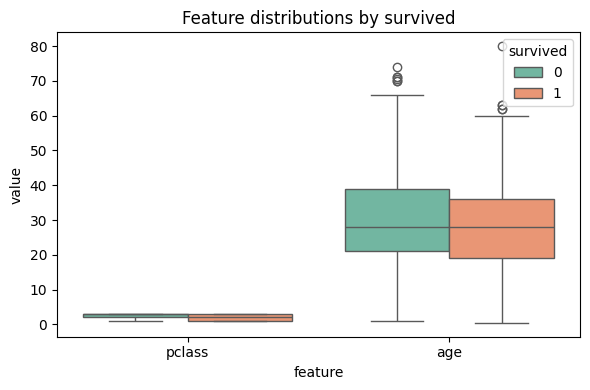


iqr_outlier_distributions.png:


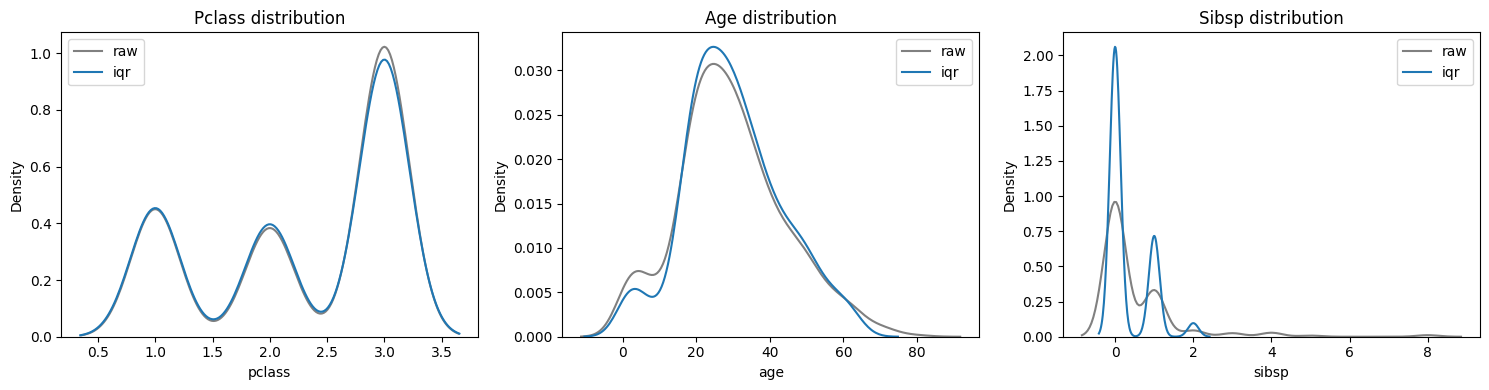


missing_values.png:


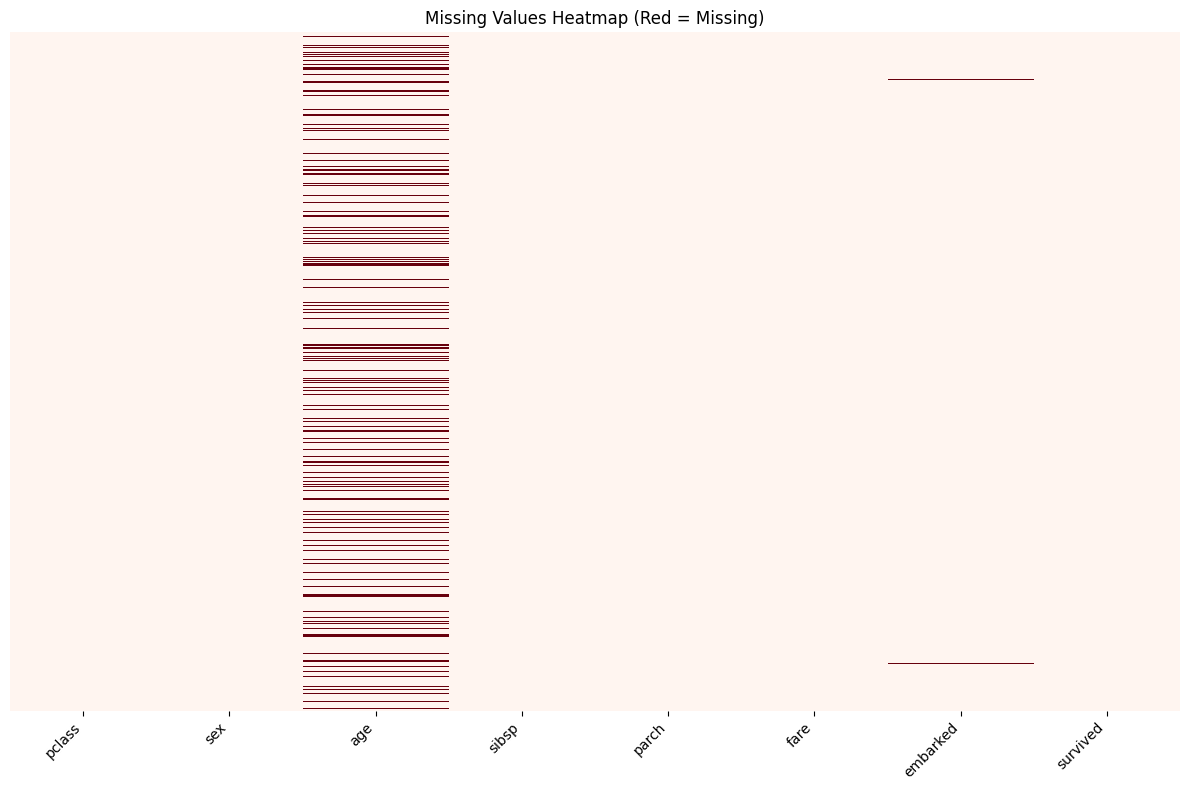


numeric_correlation_heatmap.png:


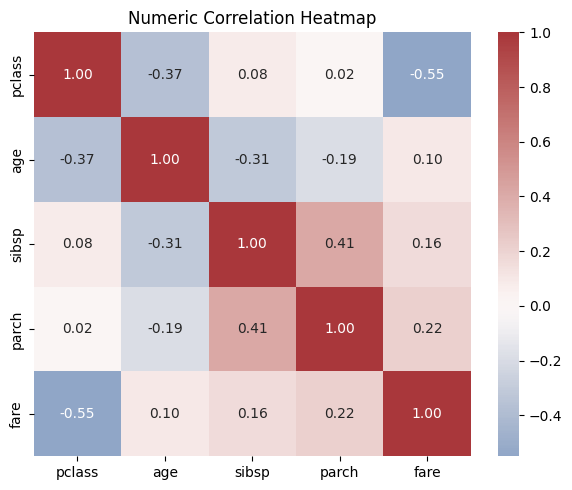


outlier_boxplots.png:


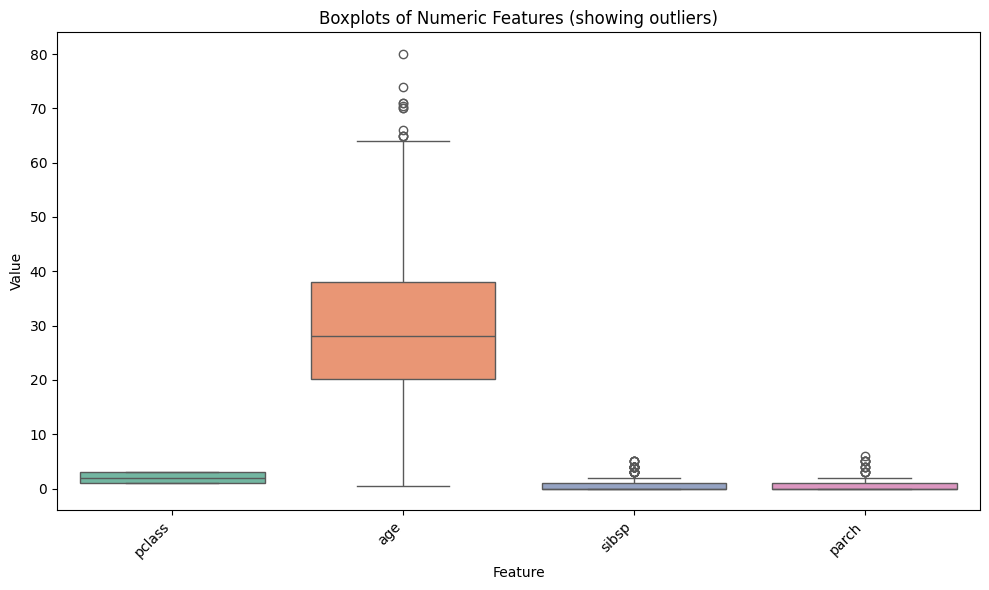


outlier_metric_comparison.png:


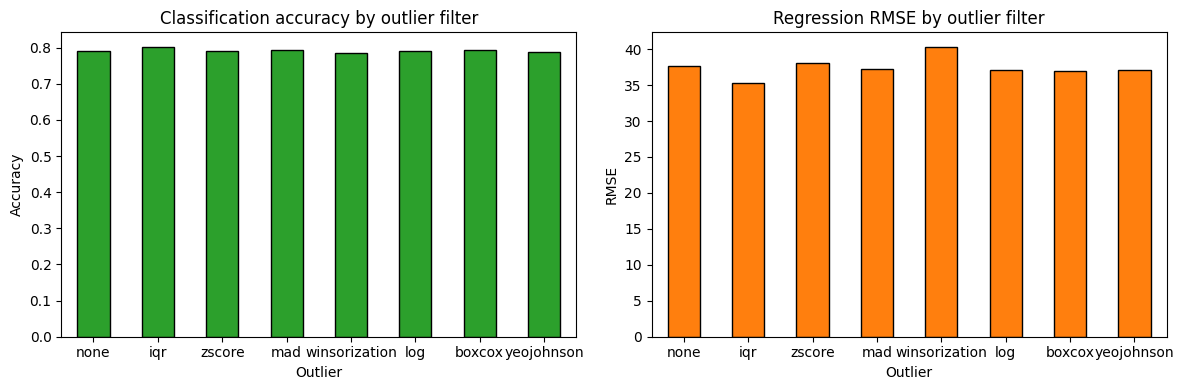

In [32]:
# Generate and display all plots
ensure_figures_dir()
log_stage("Visualization", "START")
plot_missingness(df, config)
plot_outlier_distributions(df, config)
plot_metric_comparison(classification_df, regression_df)
plot_correlation_heatmap(df, config)
plot_target_boxplot(df, config)
log_stage("Visualization", "DONE")

# Display all generated figures
if Image is not None:
    for path in sorted(FIGURES_DIR.glob("*.png")):
        print(f"\n{path.name}:")
        display(Image(str(path)))
else:
    print("Generated figures:")
    for path in sorted(FIGURES_DIR.glob("*.png")):
        print(f"  {path}")
